In [1]:
import cv2

# Load the video
cap = cv2.VideoCapture('output.avi')

# Calculate the frame number to capture
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_to_capture = total_frames//1.2

# Set the frame position
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_to_capture)

# Read the frame
ret, frame = cap.read()
if ret:
    cv2.imwrite('selected_frame.jpg', frame)
    cv2.imshow('Selected Frame', frame)
    cv2.waitKey(0)

# Clean up
cap.release()
cv2.destroyAllWindows()


In [2]:

# Global variables
refPt = []  # To store rectangle points
cropping = False

def click_and_crop(event, x, y, flags, param):
    # Access global variables
    global refPt, cropping, image, clone

    # If the left mouse button was clicked, record the starting
    # (x, y) coordinates and indicate that cropping is being performed
    if event == cv2.EVENT_LBUTTONDOWN:
        refPt = [(x, y)]
        cropping = True

    # Check to see if the left mouse button was released
    elif event == cv2.EVENT_LBUTTONUP:
        # Record the ending (x, y) coordinates and indicate that
        # the cropping operation is finished
        refPt.append((x, y))
        cropping = False

        # Draw a rectangle around the region of interest on the display image
        cv2.rectangle(clone, refPt[0], refPt[1], (0, 255, 0), 2)
        cv2.imshow("image", clone)

        # Extract the ROI from the original image using the refPt coordinates
        roi = image[refPt[0][1]:refPt[1][1], refPt[0][0]:refPt[1][0]]

        # Save the ROI
        cv2.imwrite('roi.jpg', roi)

        # Close all open windows
        cv2.destroyAllWindows()

# Load the image and create a clone for drawing
image = cv2.imread('selected_frame.jpg')
clone = image.copy()
cv2.namedWindow("image")
cv2.setMouseCallback("image", click_and_crop)

# Display the image and wait for a keypress or ROI selection
while True:
    # Display the clone image where the rectangle is drawn
    cv2.imshow("image", clone)
    key = cv2.waitKey(1) & 0xFF

    # If the 'q' key is pressed, break from the loop
    if key == ord('q'):
        break

# Close all open windows if 'q' was pressed
cv2.destroyAllWindows()


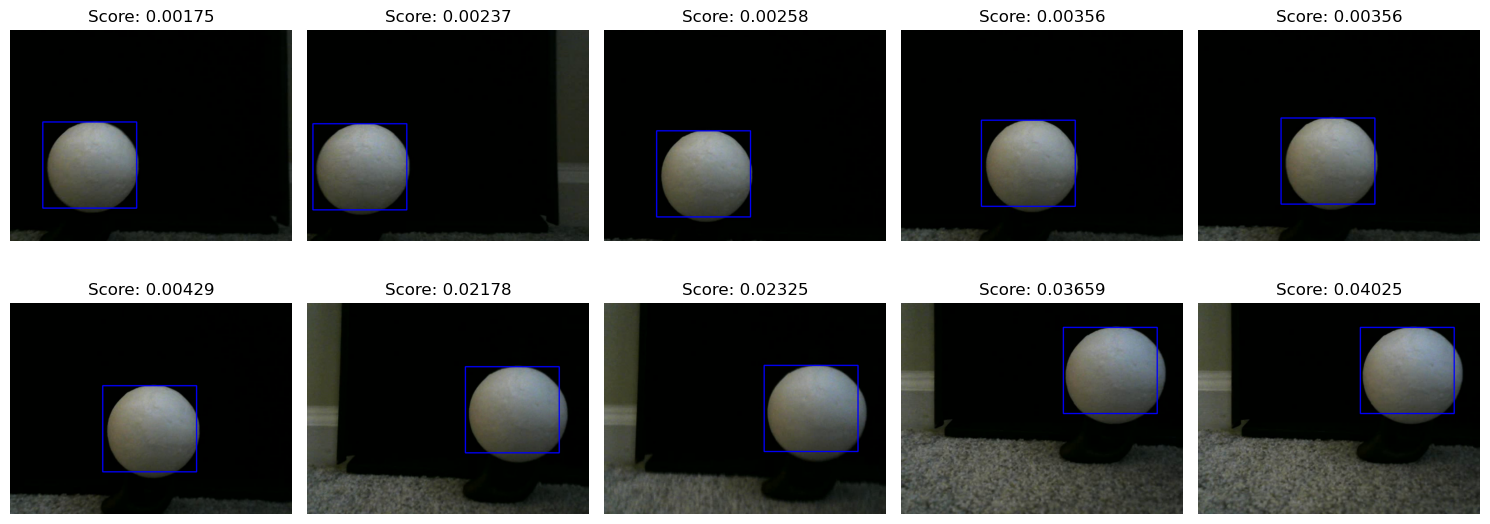

In [9]:

import numpy as np
import random
import matplotlib.pyplot as plt

# Load the ROI image
roi_img = cv2.imread('roi.jpg', cv2.IMREAD_GRAYSCALE)

# Load the video
cap = cv2.VideoCapture('output.avi')
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Randomly select 10 frames
frame_indices = sorted(random.sample(range(frame_count), 10))
matches = []
i = 0
for frame_index in frame_indices:
    # Set video to the correct frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame = cap.read()
    if not ret:
        continue

    # Convert frame to grayscale (assuming ROI is grayscale)
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Perform template matching using SSD (CV_TM_SQDIFF_NORMED method)
    result = cv2.matchTemplate(gray_frame, roi_img, cv2.TM_SQDIFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # The best match is the minimum value in case of TM_SQDIFF_NORMED
    matches.append((frame_index, min_val, frame, min_loc))
    i = i+1
    # Save the frame as an image
    frame_filename = f"Random_Selected_Frames\\frame_{i}.jpg"  # Define the filename for the frame
    cv2.imwrite(frame_filename, frame)  # Save the frame to disk

# Close video file
cap.release()

# Sort matches by SSD (lower is better)
matches.sort(key=lambda x: x[1])

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for ax, match in zip(axes.flat, matches):
    frame = match[2]
    score = match[1]
    top_left = match[3]
    bottom_right = (top_left[0] + roi_img.shape[1], top_left[1] + roi_img.shape[0])

    # Draw rectangle around the matched region
    cv2.rectangle(frame, top_left, bottom_right, (255, 0, 0), 2)
    
    # Convert color for matplotlib
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    ax.imshow(frame)
    ax.set_title(f"Score: {score:.5f}")
    ax.axis('off')

plt.tight_layout()
plt.show()
